In [17]:
import sys
print(sys.version)

3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ]


In [18]:
# Importing dependencies

import numpy as np
np.random.seed(1)
### BEGIN CHANGES - KELVIN AND JEEVAN 
### Update Tensor Flow Version.
#from tensorflow import set_random_seed
#set_random_seed(2)
import tensorflow
tensorflow.random.set_seed(2)
### END CHANGES
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
### BEGIN CHANGES - KELVIN AND JEEVAN 
### Update Keras Flow Version.
#from keras.layers.core import Dense
#from keras.layers.recurrent import GRU
from keras.layers import Dense,LSTM, Input
### END CHANGES
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [19]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

<Axes: xlabel='Date'>

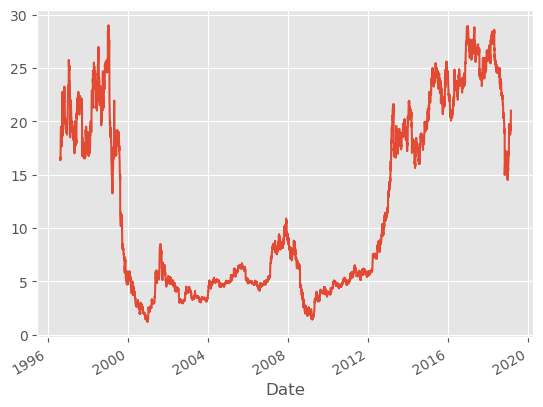

In [20]:
# Loading the dataset
url = '../CSV.csv'
df = pd.read_csv(url,parse_dates = True,index_col=0)
df.tail()

df.drop(df[df['Volume']==0].index, inplace = True)
df['Close'].plot()

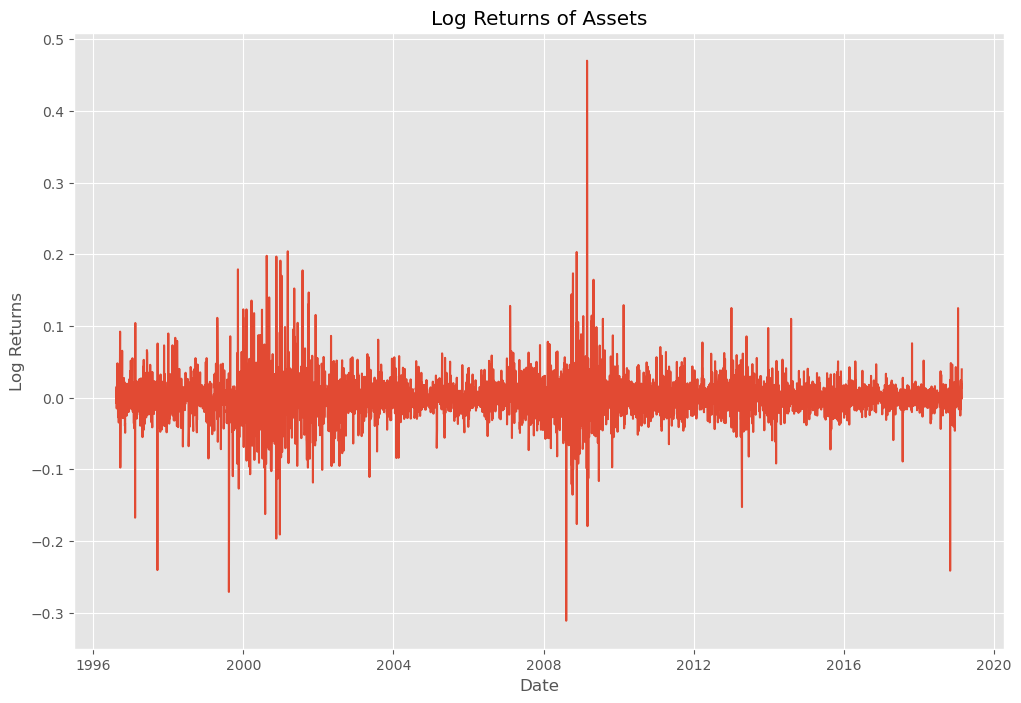

In [21]:
import numpy as np

# Calculate log returns
log_returns = np.log(df['Adj Close'] / df['Adj Close'].shift(1)).dropna()


import matplotlib.pyplot as plt

# Plot the log returns
plt.figure(figsize=(12, 8))
plt.plot(log_returns)
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Log Returns of Assets')

plt.show()

In [22]:
print("Correlation =",df['Close'].corr(df['Adj Close'])) # to check if the stocks are splitted or not in the past

Correlation = 0.9993184438375794


Since the Adj. Close and Close columns are highly correlated, we do not need to think about splittting the series.

In [23]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(1, return_sequences = True, activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(learning_rate=lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val),
                        verbose = 0, shuffle = False, callbacks=callbacks_list)
    #model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [24]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mse, rmse, r2, Y_test, Y_hat
  

In [25]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Univariate-LSTM")
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [26]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

## Model Building

(5670,)


<Axes: xlabel='Date'>

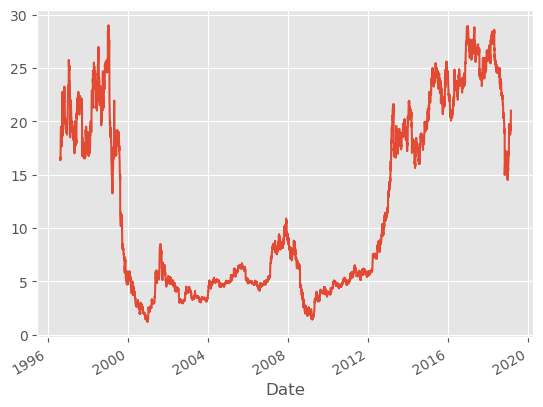

In [27]:
# Extracting the series
series = df['Close']
print(series.shape)
series.plot()

In [28]:
# Train Val Test Split
train_start = dt.date(1997,1,1)
train_end = dt.date(2006,12,31)
train_data = series.loc[train_start:train_end].values.reshape(-1,1)

val_start = dt.date(2007,1,1)
val_end = dt.date(2008,12,31)
val_data = series.loc[val_start:val_end].values.reshape(-1,1)

test_start = dt.date(2009,1,1)
test_end = dt.date(2010,12,31)
test_data = series.loc[test_start:test_end].values.reshape(-1,1)

print(train_data.shape,val_data.shape,test_data.shape)

(2515, 1) (504, 1) (503, 1)


In [29]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(2515, 1) (504, 1) (503, 1)


In [30]:
timesteps = 40
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 250

Epoch 131: early stopping


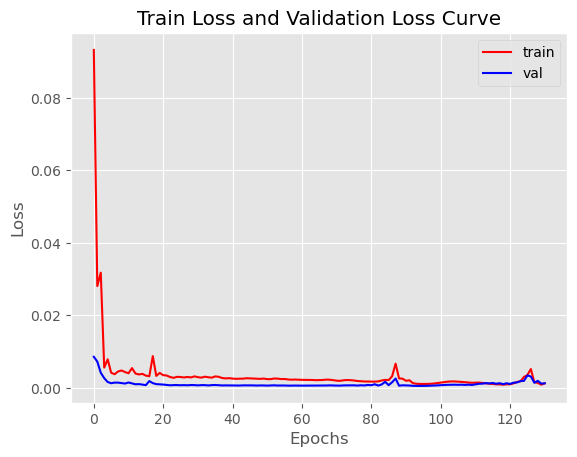

In [31]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
RMSE = 0.01353352695596714
MSE = 0.0001831563518678892
R-Squared Score = 0.830481580201169


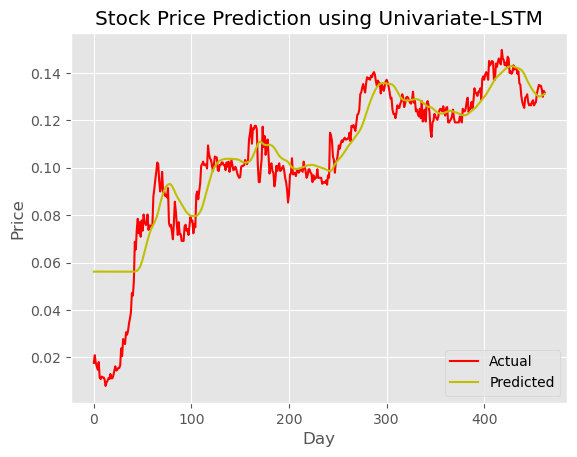

In [32]:
mse, rmse, r2, true, predicted = evaluate_model(model,test,40)
print('RMSE = {}'.format(rmse))
print('MSE = {}'.format(mse))
print('R-Squared Score = {}'.format(r2))

plot_data(true,predicted)

In [33]:
# Save a model
model.save('UV-LSTM_40_[40,35]_1e-3_64.keras')
del model
# Load a model
#model = load_model('UV-LSTM_40_[40,35]_1e-3_64.h5')

## Cross-Validation

In [34]:
# Hyperparameters
timesteps = 40
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 50

In [35]:
# Extracting the series
series = df['Close'].values.reshape(-1,1)
print(series.shape)

(5670, 1)


In [36]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:5400])
series

array([[0.5505618 ],
       [0.5505618 ],
       [0.54606742],
       ...,
       [0.91406745],
       [0.93204498],
       [0.92737079]])

### Split I

In [37]:
#Splitting the data for initial model creation
splits = 5
split_size = 600
train = series[:3*split_size]
test = series[4*split_size:5*split_size]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Split 1
MSE = 0.02115161446746314
RMSE = 0.14543594627004405
R-Squared Score = -4.097681487067336


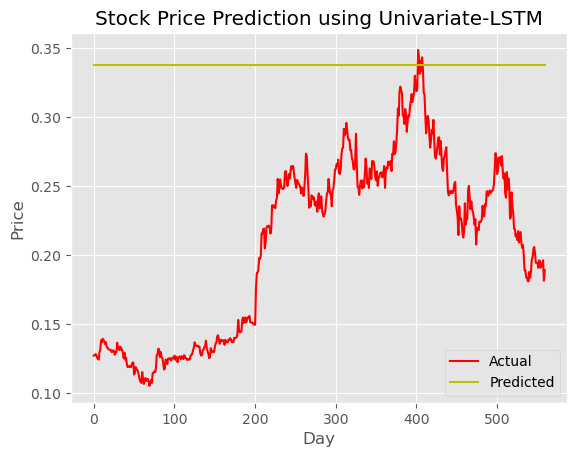

In [38]:
cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()
model,train_error,val_error = fit_model(train,test,timesteps,hl,lr,batch_size,num_epochs)
train_loss['Split1'] = train_error
val_loss['Split1'] = val_error
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,0])
model.save("UV-LSTM-Split1.keras")

### Split II

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Split 2
MSE = 0.01875612580613012
RMSE = 0.1369530058309423
R-Squared Score = -3.5203525923798162


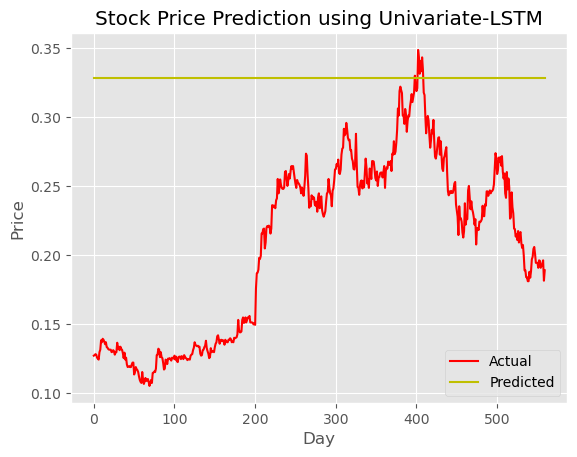

In [39]:
train = series[:4*split_size]
test = series[4*split_size:5*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split2"] = history.history['loss']
val_loss["Split2"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("UV-LSTM-Split2.keras")

### Split III

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Split 3
MSE = 0.042786464728013195
RMSE = 0.20684889346576935
R-Squared Score = -27.52083042271299


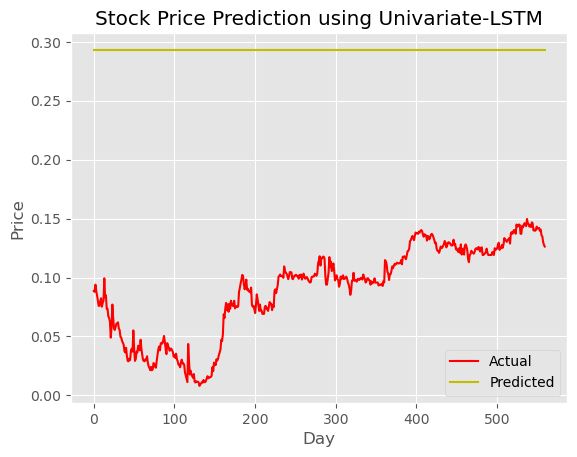

In [40]:
train = series[:5*split_size]
test = series[5*split_size:6*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split3"] = history.history['loss']
val_loss["Split3"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("UV-LSTM-Split3.keras")

### Split IV

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Split 4
MSE = 0.02025309073571647
RMSE = 0.14231335403157522
R-Squared Score = -0.011951007725980123


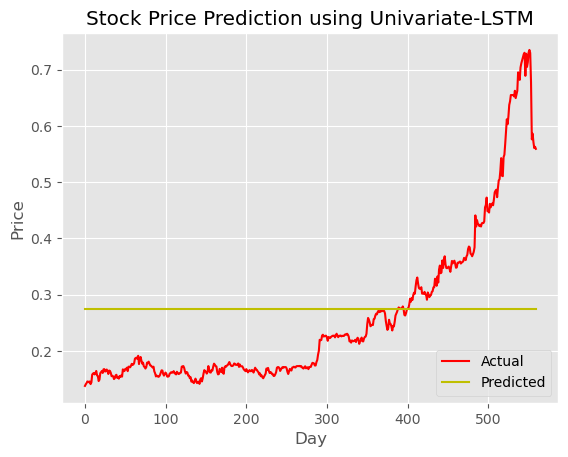

In [41]:
train = series[:6*split_size]
test = series[6*split_size:7*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split4"] = history.history['loss']
val_loss["Split4"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 4")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("UV-LSTM-Split4.keras")

### Split V

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Split 5
MSE = 0.19241584153419933
RMSE = 0.4386523014121769
R-Squared Score = -20.899974952749673


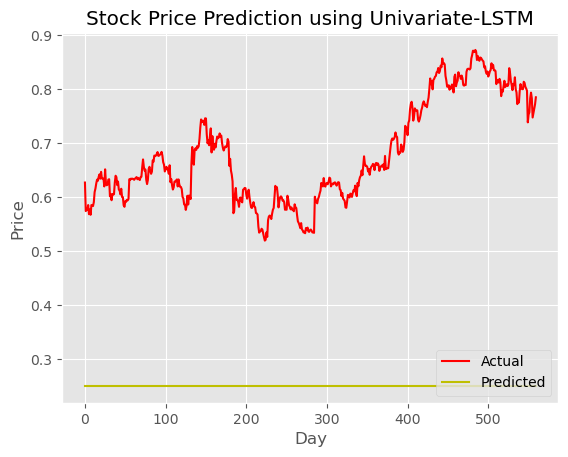

In [42]:
train = series[:7*split_size]
test = series[7*split_size:8*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split5"] = history.history['loss']
val_loss["Split5"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 5")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("UV-LSTM-Split5.keras")

In [43]:
CV_results = pd.DataFrame(cross_val_results,columns=['MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MSE = {}".format(CV_results['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_results['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_results['R2_Score'].mean()))

Avg. MSE = 0.05907262745430445
Avg. RMSE = 0.21404070020210159
Avg. R2-score = -11.210158092527161


In [44]:
CV_results.to_csv('UV-LSTM_CrossValidation.csv')
train_loss.to_csv('UV-LSTM_CrossValidation_TrainLoss.csv')
val_loss.to_csv('UV-LSTM_CrossValidation_ValLoss.csv')